In [102]:
from pandas.tslib import Timestamp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [103]:
## Make sure you have statsmodels 0.7.0 or newer installed!!!!!

import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')

In [168]:
def acf_pacf(ts, lags):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(ts, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(ts, lags=lags, ax=ax2)

In [201]:
def get_data_by_month(df):
    df_reindexed = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max(), freq='1D'), fill_value=0)
    ym_series = pd.Series(df_reindexed.reset_index()['index'].\
          apply(lambda dt: pd.to_datetime(
            dt.to_datetime().year*10000 + dt.to_datetime().month*100 + 1, format='%Y%m%d')))

    df_reindexed['activity_ym'] = ym_series.values
    return df_reindexed.groupby(['activity_ym']).amount.sum().to_frame()

### Time Series analysis

In [209]:
donations = pd.read_pickle('out/21/donations.pkl')

In [288]:
df = donations\
    .groupby(['activity_date', ])\
    .amount\
    .sum()\
    .to_frame()
df = get_data_by_month(df)

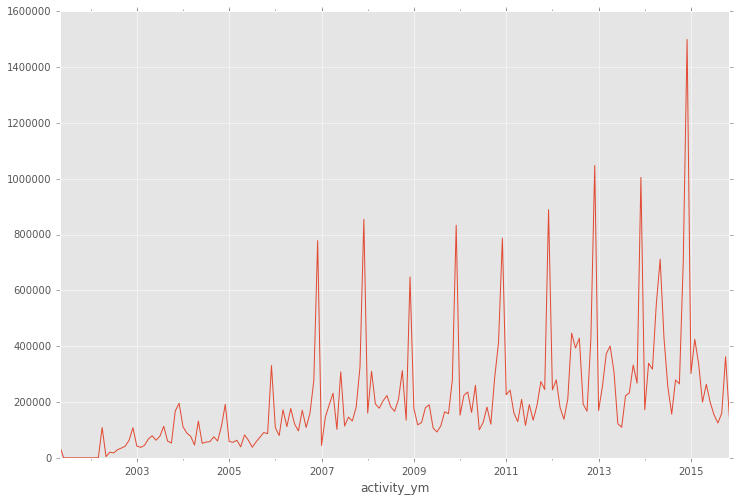

In [289]:
ts = pd.Series(df['amount'])
ts.plot(figsize=(12,8))

### The plot of the data shows that the data was much different before 2003.
#### So let us only consider data from 2003 onwards and plot the data again.
Observations

Original variable (amount) - (ts):
1. The original variable is itself not stationary.
2. The pacf and acf on the original variable cut off at lag of 1.
3. The acf on the original variable indicates seasonality at 12 months.

Differenced variable (ts_diff):
1. The differenced variable has mean 0 but has significant variability that is increasing.

Log transformation on the original variable (log_ts):
1. The log is also not stationary.
2. The acf on log_ts show cut off at lag of 2.
3. The pacf on log_ts show cut off at lag of 1.


Difference on the log transformation on the original variable (log_ts_diff):
1. The difference in the log appears to be stationary with mean 0 and constant variance from the plot of log_ts_diff.

Considering the seasonal portion of log_ts:
1. The acf shows a gradual tailing off.
2. The pacf indicates a cut off at lag of 2.

Based on the above, we want to try out the following seasonal ARIMA models on log of the original variable:

(p=2, d=1, q=1), (P=0, D=1, Q=2, S=12) => model1


In [343]:
df = donations[donations.activity_year >= 2008]\
    .groupby(['activity_date', ])\
    .amount\
    .sum()\
    .to_frame()
df = get_data_by_month(df)

In [344]:
df.head()

,amount
activity_ym,
2008-01-01,160111
2008-02-01,310280
2008-03-01,193131
2008-04-01,177700
2008-05-01,204409


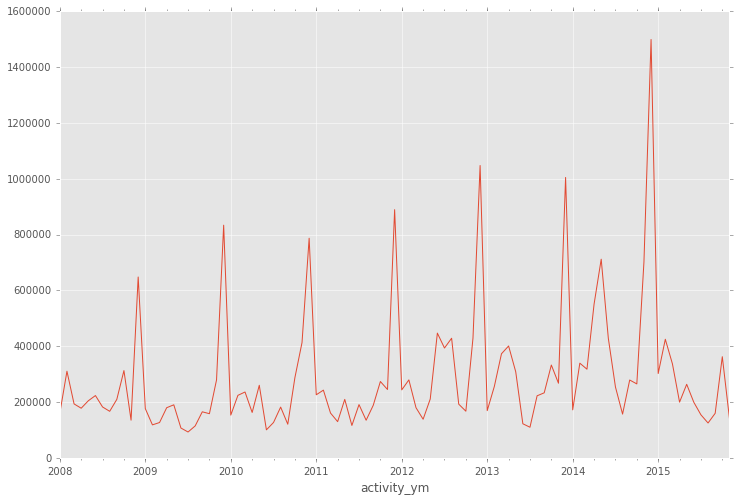

In [360]:
ts = pd.Series(df['amount'])
ts.plot(figsize=(12,8))

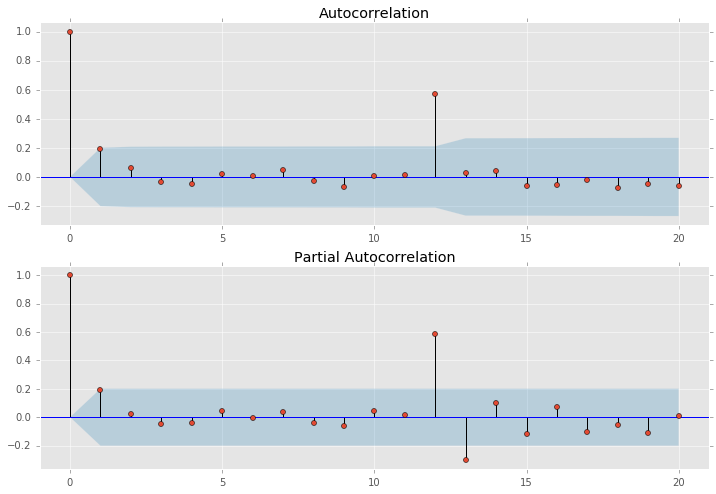

In [361]:
acf_pacf(ts, 20)

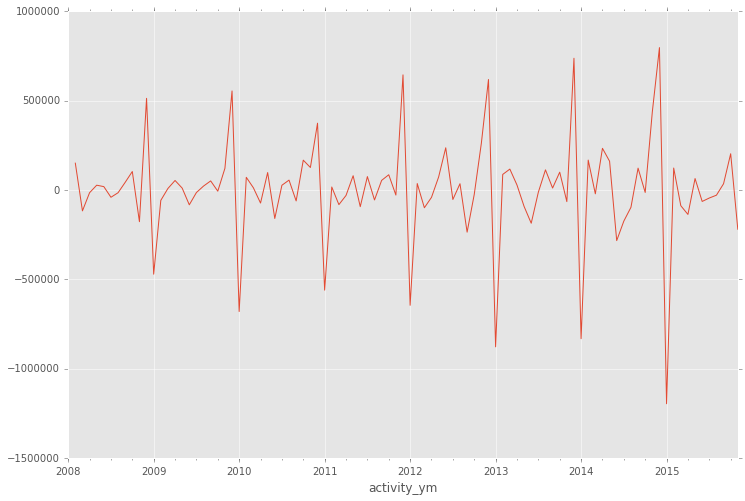

In [362]:
ts_diff=ts.diff(1)
ts_diff.plot(figsize=(12,8))

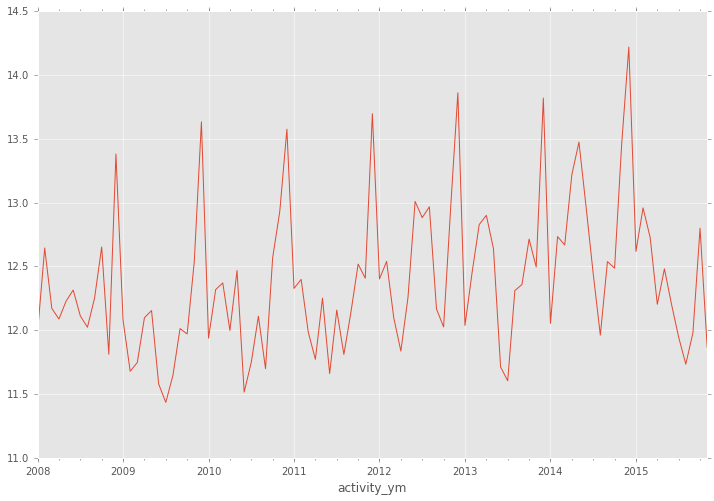

In [364]:
log_ts = np.log(pd.Series(df['amount']))
log_ts.plot(figsize=(12,8))

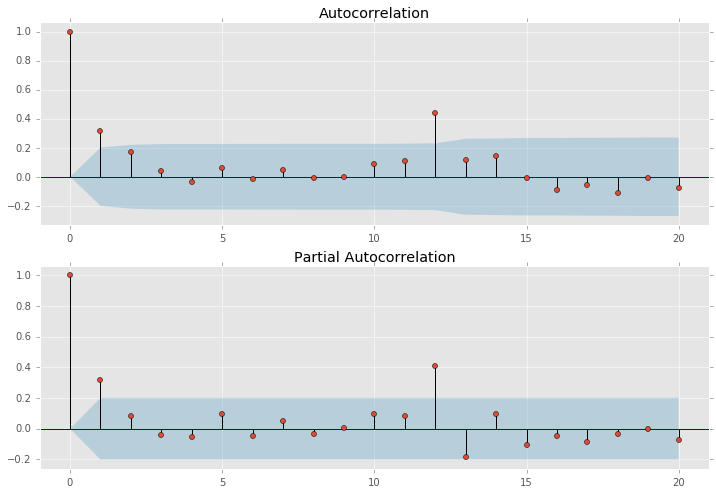

In [368]:
acf_pacf(log_ts, 20)

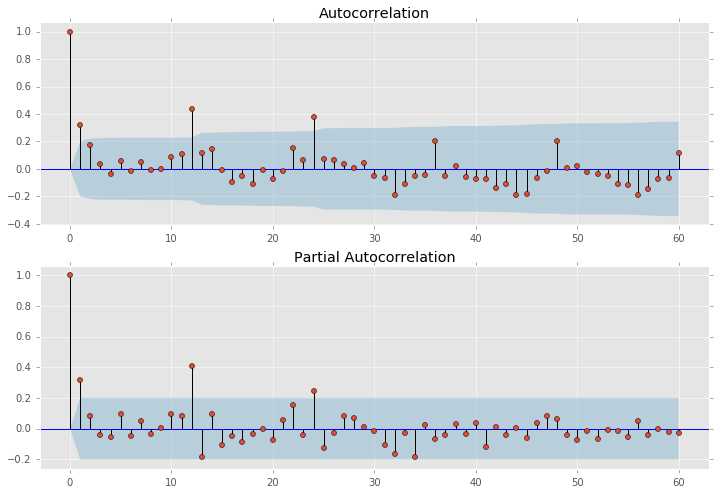

In [370]:
acf_pacf(log_ts, 60)

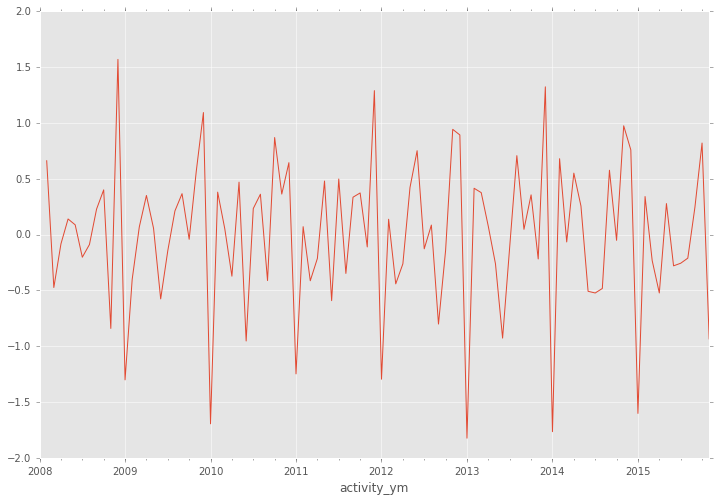

In [371]:
log_ts_diff=log_ts.diff(1)
log_ts_diff.plot(figsize=(12,8))

In [ ]:
(p=2, d=1, q=1), (P=0, D=1, Q=2, S=12) => model1
(p=2, d=1, q=1), (P=0, D=1, Q=1, S=12) => model2


In [402]:
model=sm.tsa.SARIMAX(log_ts, order=(0,1,0), seasonal_order=(2,1,0,12)).fit() # , enforce_invertibility=False
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             amount   No. Observations:                   95
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 -60.932
Date:                            Sat, 09 Jan 2016   AIC                            127.864
Time:                                    18:55:41   BIC                            135.526
Sample:                                01-01-2008   HQIC                           130.960
                                     - 11-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8250      0.136     -6.051      0.000      -1.092      -0.558
ar.S.L24      -0.4061      0.142     -2.864      0.004      -0.684      -0.128
sigma2         0.2308      0.034      6.838      0.000       0.165       0.297
===================================================================================
Ljung-Box (Q):                       37.95   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.56   Prob(JB):                         0.58
Heteroskedasticity (H):               1.26   Skew:                             0.20
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients.
"""

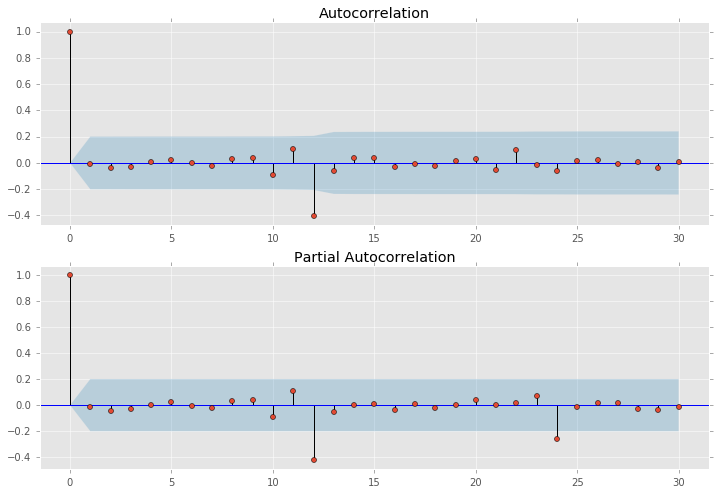

In [400]:
acf_pacf(model.resid, 30)